In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


### MLP
- **character embedding**
- multi-layer perceptron architecture
- hyper parameter tuning

### Build Dataset
train: val: test = 8: 1: 1

In [154]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [153]:
_, _ = build_dataset(words[:1])

... ---> m
..m ---> e
.me ---> l
mel ---> e
ele ---> a
lea ---> h
eah ---> .


In [155]:
import random
random.seed(2025)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(n1, n2)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 28829
torch.Size([182601, 3]) torch.Size([182601])
torch.Size([22828, 3]) torch.Size([22828])
torch.Size([22717, 3]) torch.Size([22717])


### Build the Model

#### Neural network architecture
[Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
<div align="center">
  <img src="./neural_architecture.png" alt="The neural network architecture" width="500" height="auto" />
</div>

#### Character Embedding

**Curse of Dimensionality**<br>
`context` length is 1: predicting using 1 character. 27 classes of inputs -> A lookup table of 27 x 27   
`context` length is 2: 27x27=729 classes of inputs -> A lookup table of 729 x 27 ?  
`context` length is 3: 27x27x27=19,683 classes of inputs -> A lookup table of 19683 x 27?

An embedding matrix turns categorical representation into numerical representation.For a 2-D embedding matrix, each character is repsented by a point in a 2-D plain.   

**Embedding matrix has shape `(27,2)`<br> `(1,27) @ (27,2) -> (1, 2)`**

In [7]:
X = Xtr[:5]
Y = Ytr[:5]
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 15],
        [ 5, 15,  9],
        [15,  9, 14]])

In [8]:
C = torch.randn((27, 2))
C[:10]

tensor([[-2.1839,  0.9079],
        [-0.0454,  1.4576],
        [ 1.0495,  0.1140],
        [-1.7751, -0.9349],
        [ 1.6112,  0.8838],
        [-1.2912, -0.6919],
        [ 0.1066,  0.1655],
        [ 3.0553, -0.1134],
        [ 0.1330, -0.3087],
        [-1.1925,  1.0233]])

In [9]:
emb = C[X]
X.shape, emb.shape

(torch.Size([5, 3]), torch.Size([5, 3, 2]))

In [10]:
# Embedding of context of 3 is essentially 3 (x, y) locations in the 2-D embedding space
emb.view(X.shape[0], -1)

tensor([[-2.1839,  0.9079, -2.1839,  0.9079, -2.1839,  0.9079],
        [-2.1839,  0.9079, -2.1839,  0.9079, -1.2912, -0.6919],
        [-2.1839,  0.9079, -1.2912, -0.6919, -0.0678,  0.5567],
        [-1.2912, -0.6919, -0.0678,  0.5567, -1.1925,  1.0233],
        [-0.0678,  0.5567, -1.1925,  1.0233, -1.2733,  0.0387]])

#### First layer

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
l = emb.view(X.shape[0], -1) @ W1 + b1

In [13]:
h = torch.tanh(l)

#### Second layer

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

#### Softmax

In [16]:
counts = logits.exp()

In [17]:
prob = counts / counts.sum(1, keepdims=True)

In [18]:
prob.shape

torch.Size([5, 27])

#### Loss function

In [19]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(15.6028)

#### Cross Entropy Function

Applying a softmax followed by a negative log likelihood function is equivalent to 
[`torch.nn.functional.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)

In [20]:
loss = F.cross_entropy(logits, Y)
loss

tensor(15.6028)

### training

In [21]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182572, 3]), torch.Size([182572]))

In [22]:
emb_dim = 2
hidden_size = 100

g = torch.Generator().manual_seed(2025) # for reproducibility

C  = torch.randn((27, emb_dim),                     generator=g)
W1 = torch.randn((emb_dim*block_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size,                       generator=g)
W2 = torch.randn((hidden_size, 27),                 generator=g)
b2 = torch.randn(27,                                generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [23]:
stepi, lossi = [], []
num_epochs = 100
batch_size = 32
lr = 0.1

In [24]:
for i in range(num_epochs):

  # emb = C[Xtr]
  # Y = Ytr

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  emb = C[Xtr[ix]] # (32, 3, 10)
  Y = Ytr[ix]
  
  # forward pass
  h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

3.6756339073181152


In [25]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.6432, grad_fn=<NllLossBackward0>)

In [26]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(3.6220, grad_fn=<NllLossBackward0>)

### Hyperparameter Tuning
- Training loss and Validation loss are roughly equal which means our model is not powerful enough to overfitting.We are currently under fitting. Because our model is very small. `hidden_size`: 100 -> 300
- Even we make the hidden layer layer bigger, it could be that the bottleneck is that the embedding space is too small. `emb_dim`: 2 -> 10.
- We see a lot of noise in the loss. One possible reason is that the batch size is too low, a lot of gradient deviations per training. `batch_size`: 32 -> 128
- Change the learning rate. `lr`: 0.1 -> 0.05
- how long we are running
- batch size, achieve a optimized converging speed, how many minutes does it take to train your model to get the loss to it. 
- What is the learning rante nad how does it change over time?
- The number of characters used to predict the character

### Learning rate

|lr|0.0001|0.001|0.01|0.1|1|10|100|
|---|---|---|---|---|---|---|---|
|Loss|10.725|3.269|2.611|2.501|2.466|52.23|580|

Lower limit: 0.001<br>
Upper limit: 1

In [88]:
# get a sense of lower and upper limit of the lr, make a sequence of it
lre = torch.linspace(-3, 0, 2000)
lrs = 10**lre

In [89]:
emb_dim = 2
hidden_size = 100

g = torch.Generator().manual_seed(2025) # for reproducibility
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [90]:
lri = []
lossi = []
stepi = []

In [91]:
for i in range(2000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  # lr = 100
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lr)
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [92]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(6.2909, grad_fn=<NllLossBackward0>)

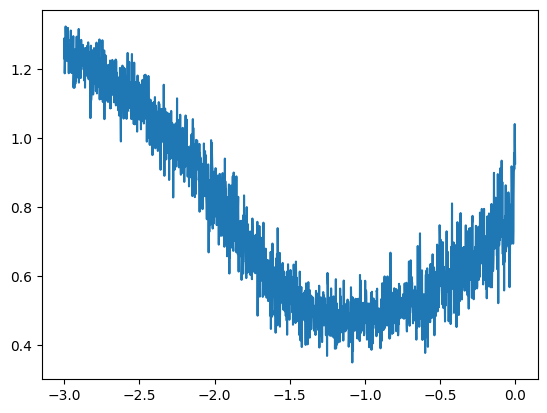

In [93]:
import numpy as np
plt.plot(np.log10(lri), lossi)

#### underfitting/overfitting

In [132]:
emb_dim = 2
hidden_size = 200

g = torch.Generator().manual_seed(2025) # for reproducibility
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total

6881

In [133]:
loss_tr = []
loss_dv = []
stepi = []

In [139]:
num_epochs = 50000
batch_size = 128
lr = 0.1

for i in range(num_epochs):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  loss_tr.append(loss.log10().item())

In [140]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2797, grad_fn=<NllLossBackward0>)

In [141]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2935, grad_fn=<NllLossBackward0>)

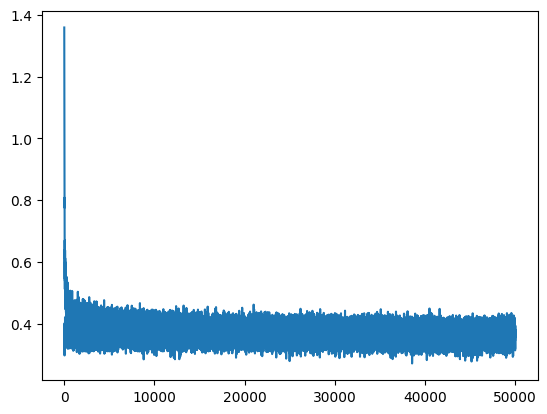

In [142]:
import numpy as np
plt.plot(stepi, loss_tr)

### visualization of embedding space

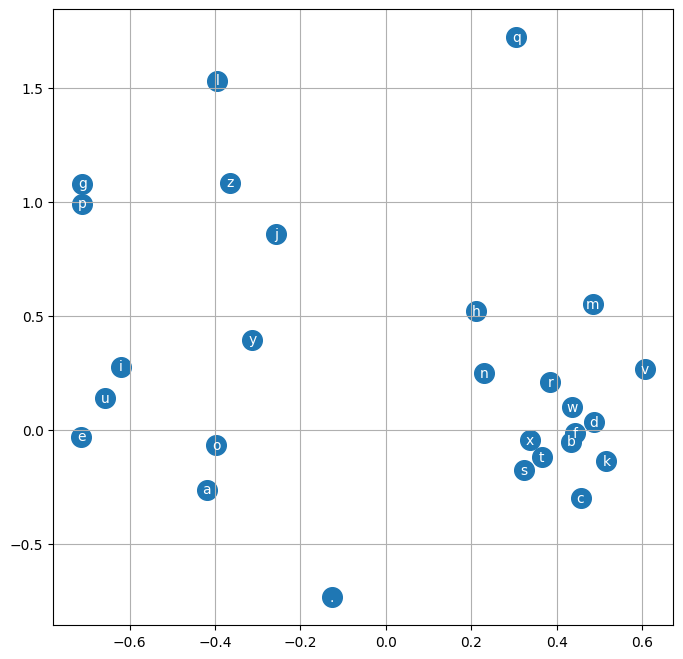

In [143]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [156]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 2])

In [157]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzatelle.
khi.
mili.
thick.
kanden.
jazonen.
dresric.
kaeli.
nellari.
chaiiv.
kaleigh.
ham.
pois.
quint.
sroilea.
vadiquis.
elo.
diaryxi.
jace.
pirra.
